In [6]:
!pip install tensorflow

     ---------------------------------------- 5.5/5.5 MB 1.2 MB/s eta 0:00:00
  Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 0.4.6
    Uninstalling google-auth-oauthlib-0.4.6:
      Successfully uninstalled google-auth-oauthlib-0.4.6
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0


In [2]:
pip install --upgrade tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"train",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [6]:
class_names= dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [7]:
len(dataset)

313

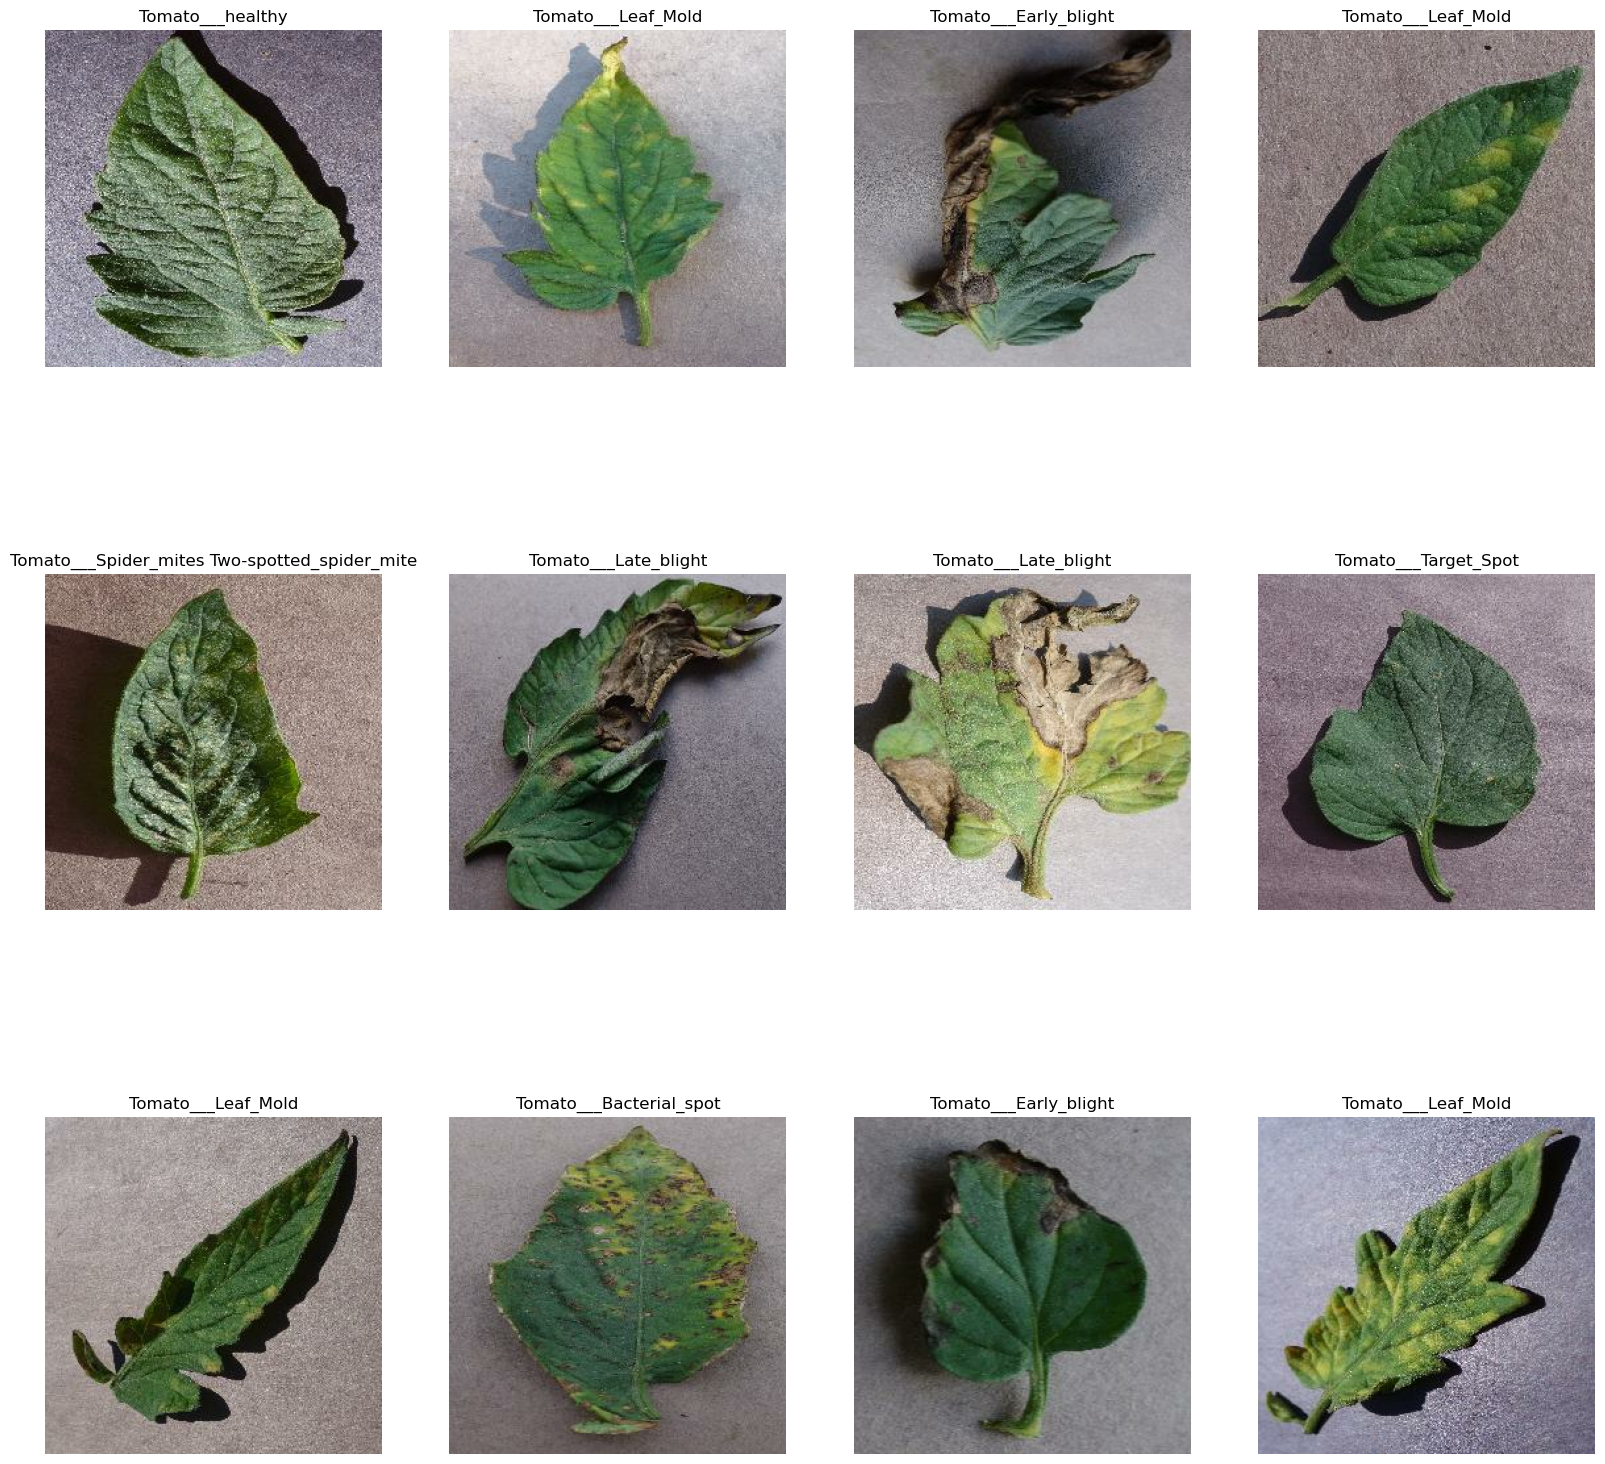

In [9]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for a in range(12):
        ax= plt.subplot(3,4,a+1)
        plt.imshow(image_batch[a].numpy().astype("uint8"))
        plt.title(class_names[label_batch[a]])
        plt.axis("off")
#     print(image_batch[0].shape)


In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

250

In [13]:
len(val_ds)

31

In [14]:
len(test_ds)

32

In [15]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [18]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=10
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
]
)
model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
history=model.fit(
 train_ds,
epochs=EPOCHS,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds)

Epoch 1/50



C:\Users\hp\anaconda3\lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



250/250 [==============================] - 276s 1s/step - loss: 1.8861 - accuracy: 0.3518 - val_loss: 1.5916 - val_accuracy: 0.4940
Epoch 2/50
250/250 [==============================] - 246s 982ms/step - loss: 1.0431 - accuracy: 0.6409 - val_loss: 1.8215 - val_accuracy: 0.4929
Epoch 3/50
250/250 [==============================] - 240s 959ms/step - loss: 0.7853 - accuracy: 0.7256 - val_loss: 1.3932 - val_accuracy: 0.6048
Epoch 4/50
250/250 [==============================] - 239s 957ms/step - loss: 0.6593 - accuracy: 0.7647 - val_loss: 2.1328 - val_accuracy: 0.5605
Epoch 5/50
250/250 [==============================] - 239s 954ms/step - loss: 0.5838 - accuracy: 0.7933 - val_loss: 0.8974 - val_accuracy: 0.7409
Epoch 6/50
250/250 [==============================] - 240s 958ms/step - loss: 0.4872 - accuracy: 0.8254 - val_loss: 0.9419 - val_accuracy: 0.7450
Epoch 7/50
250/250 [==============================] - 239s 958ms/step - loss: 0.4782 - accuracy: 0.8352 - val_loss: 0.5903 - val_accuracy

In [22]:
scores=model.evaluate(test_ds)

32/32 [==============================] - 61s 297ms/step - loss: 0.2960 - accuracy: 0.8984


In [23]:
scores

[0.29599523544311523, 0.8984375]

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 250}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

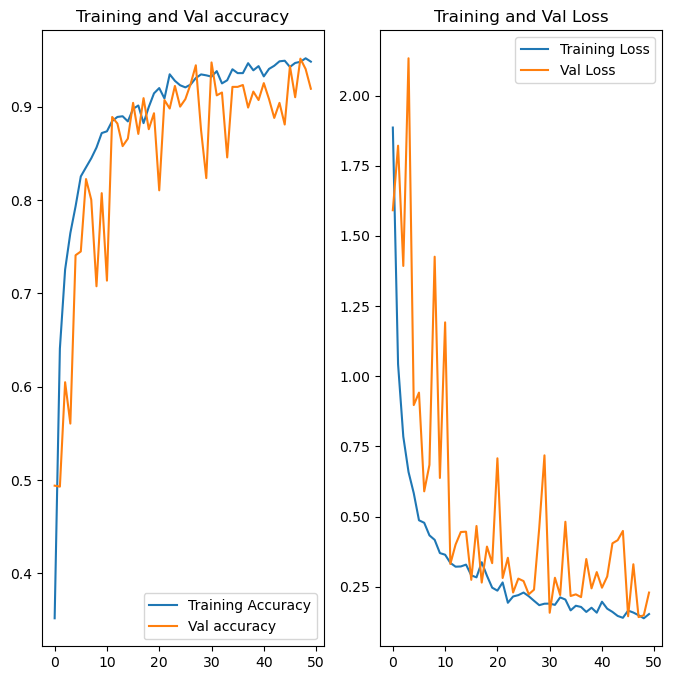

In [28]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Val accuracy')
plt.legend(loc='lower right')
plt.title("Training and Val accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Val Loss')
plt.legend(loc='upper right')
plt.title("Training and Val Loss")
plt.show()

Pred
Actual: Tomato___Target_Spot
1/1 [==============================] - 2s 2s/step
Pred label: Tomato___Leaf_Mold


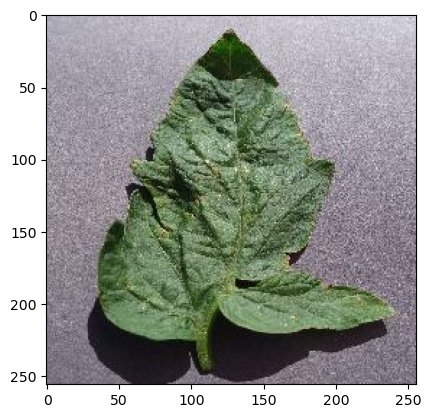

In [29]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("Pred")
    plt.imshow(first_image)
    print("Actual:",class_names[first_label])
    batch_pred=model.predict(images_batch)
    print("Pred label:",class_names[np.argmax(batch_pred[11])])

In [30]:
def pred(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 31ms/step


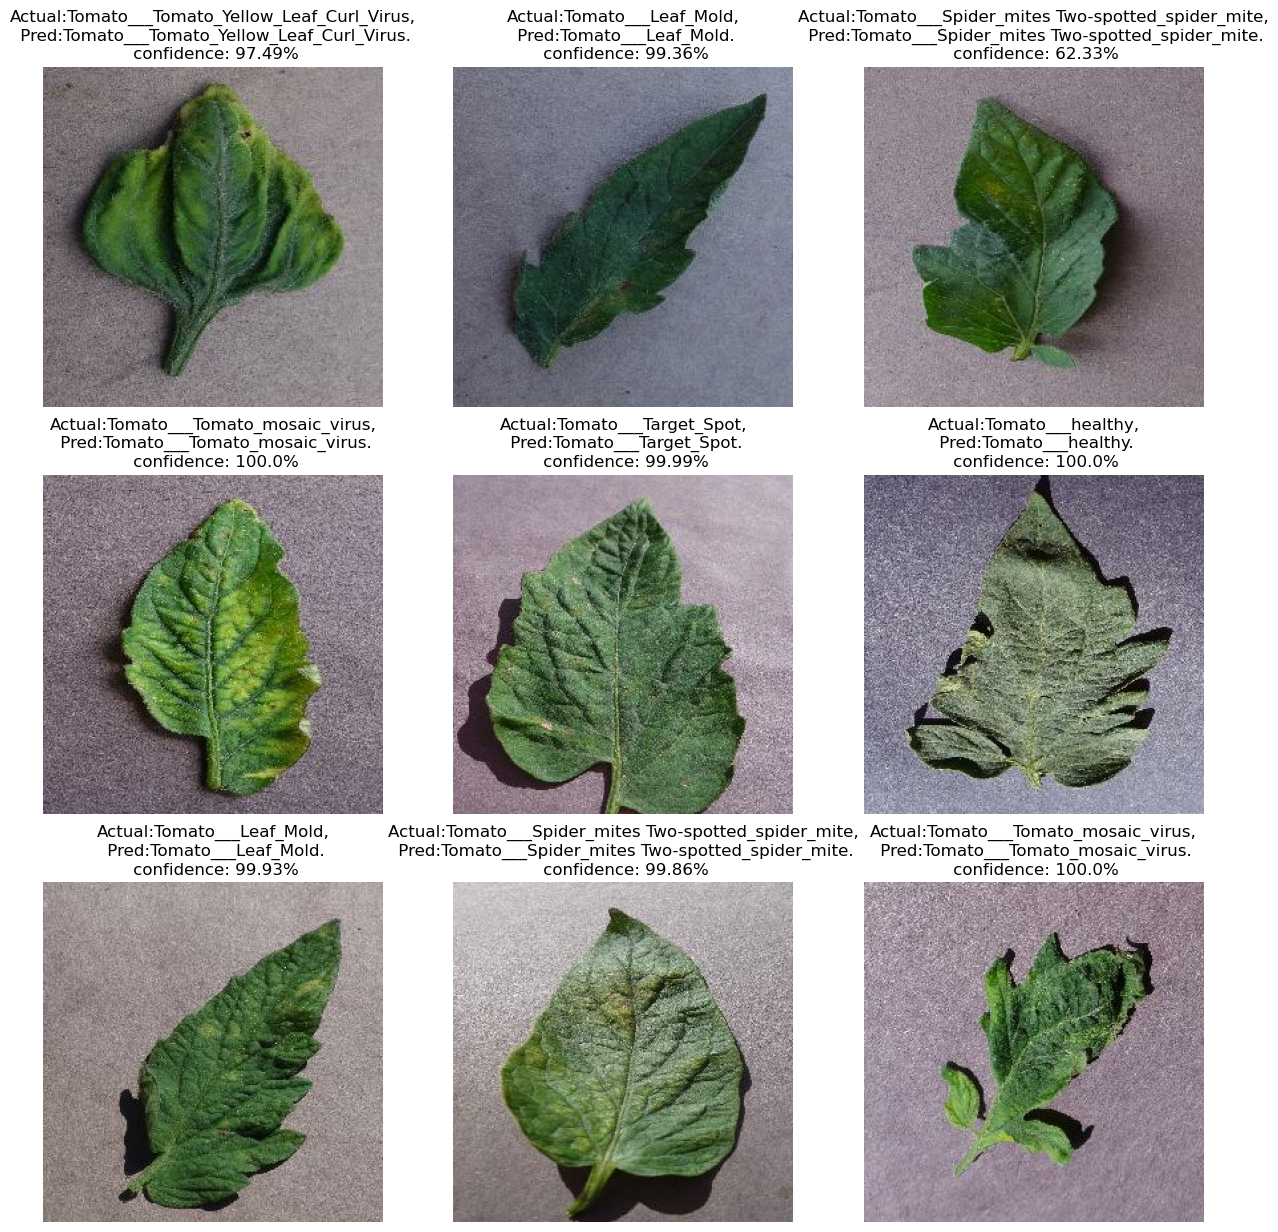

In [31]:
plt.figure(figsize=(15,15))
for i in range(9):
    for images,labels in test_ds.take(1):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class,confidence=pred(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Pred:{predicted_class}.\n confidence: {confidence}%")
        plt.axis("off")

In [48]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets


In [49]:
model.save("../potatoes.h5")

C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
